<a href="https://colab.research.google.com/github/psilvaf/ictp-2021-lss-surveys/blob/main/sol_Exercise_2_sigma_dndlnM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: $\sigma(R, z)$ (including $\sigma_8$) and the mass function.

We will now start from our code for the power spectrum, and code up the amplitude of mass fluctuations $\sigma(R, z)$.  Then we will take that knowledge to calculate the mass function $dn/d\ln M$, and finally predict cluster counts in a survey.

First, load up the usual functins that we shall need.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad # will need for integration ('quadrature')

###########################################################################
### The block below is entirely optional; it just makes the plots look good
### You can copy it to all ipynb files that you do, or not, up to you
### requires the myplot_style.txt file that you upload as below
### (I will be providing that file)
###########################################################################

'''# figure size and resolution
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# style file to make plots look nice (large labels etc)
from google.colab import files
src = list(files.upload().values())[0]
open('myplot_style.txt','wb').write(src)

# I will be providing this file - this is optional as I said
plt.style.use('myplot_style.txt')'''

"# figure size and resolution\nplt.rcParams['figure.figsize'] = [12, 8]\nplt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower\n\n# style file to make plots look nice (large labels etc)\nfrom google.colab import files\nsrc = list(files.upload().values())[0]\nopen('myplot_style.txt','wb').write(src)\n\n# I will be providing this file - this is optional as I said\nplt.style.use('myplot_style.txt')"

Then define the base cosmo parameters

In [1]:
Om=0.2
Ok=0.0
w=-1.0
ns=0.963
A = 2.1e-9 # at k=0.05
H0 = 67.0
Ob=0.022396 *(100/H0)**2 

Then, add the distance functions.

In [3]:
def dist_integrand(z, Om, Ok, w):
    Ol = 1 - Om - Ok
    return 1.0/np.sqrt(Om*(1+z)**3 + Ol*(1+z)**(3*(1+w)) + Ok*(1+z)**2)

SMALL = 1.0e-5  # some small number, doesn't matter what

# this is really H0 r(z)!
def rz(z, Om, Ok, w):
    chi = quad(dist_integrand, 0, z, args=(Om, Ok, w))[0]
    if (Ok > SMALL):
        return np.sinh(np.sqrt(Ok)*chi) / np.sqrt(Ok) # open
    elif (Ok < -SMALL):
        return np.sin(np.sqrt(-Ok)*chi) / np.sqrt(-Ok) # closed
    else:
        return chi

Now code up the linear growth function. 
The exact equation, valid for all w(z) CDM model is given in the lecture notes. 
However here, you can use an approximate expression from Carroll, Press & Turner (1992) which holds for flat LCDM models:

$g(z)\simeq\displaystyle\frac{5}{2}\,
{\displaystyle\Omega_M(z)\over \Omega_M(z)^{4/7} - \Omega_\Lambda(z) + \left [1+\displaystyle {1\over 2}\Omega_M(z)\right ]\left [1+\displaystyle{1\over 70}\Omega_\Lambda(z)\right ]}$

How do you go from $g(a)$ to $D(a)$? And which one, if either, actually enters $P(k)$??


In [4]:
# g(a) growth function; assumes flat and LCDM
def ga_LCDM(z, Om):  
    # Omega_M(z)
    Om_z = Om*(1+z)**3 / (Om*(1+z)**3 + (1-Om))
    # Omega_L(z)
    Ol_z = 1.0-Om_z

    numerator   = 2.5 * Om_z 
    denominator = Om_z**(4.0/7) - Ol_z + (1+0.5*Om_z) * (1 + 1.0/70*Ol_z)
    return numerator/denominator

# a*g(a) 
def a_times_ga_LCDM(z, Om):      
    return ga_LCDM(z, Om)/(1+z)

# D(a) = a*g(a)/g(1))
def Da_LCDM(z, Om):
    return a_times_ga_LCDM(z, Om)/ga_LCDM(0, Om)


Code up the transfer function. For simplicity, use the simple BBKS transfer function (Bardeen, Bond, Kaisser, Szalay 1987):

In [5]:
# BBKS transfer function; k needs to be in Mpcinv
def TF_BBKS(k_Mpcinv, h, Om, Ob):    
    Gamma=Om*h*np.exp(-Ob-1.3*Ob/Om) # not original BBKS, but more accurate
    qval = k_Mpcinv/(Gamma*h)
    return np.log(1+2.34*qval)/(2.34*qval)* (1 + 3.89*qval + (16.1*qval)**2 + (5.46*qval)**3 + (6.71*qval)**4)**(-0.25)

Now a big moment - define the linear-theory power spectrum $P(k, z)$.  We gave the formula for the dimensionless version $\Delta^2(k)$ in the lecture notes:

$ \Delta^2(k, a)\equiv \displaystyle{k^3 P(k)\over 2\pi^2}=A\,{4\over 25}
{1\over \Omega_M^2}\left ({k\over k_{\rm piv}}\right )^{n-1}
\left ({k\over H_0}\right )^4 \,
[a g(a)]^2\, T^2(k)$

Define a function for the linear $\Delta^2(k, z)$.

In [6]:
# linear dimensionless matter power spectrum, Delta^2(z, k)
def Deltasq_Pk_linear(z, k, A_k005, H0, Om, Ob, ns): # k is in h Mpc^{-1}
    growth =  a_times_ga_LCDM(z, Om)
    h        = H0/100.0
    H0_hMpcinv  = 1.0/2997.9  
    k_Mpcinv = k*h
    k_fid    = 0.05    ## Planck expands around this; in Mpc^{-1}
    transfer = TF_BBKS(k_Mpcinv, h, Om, Ob)
    return 4.0/25 * A_k005 * Om**(-2) * (k_Mpcinv/k_fid)**(ns-1) * (k/H0_hMpcinv)**4 * (growth*transfer)**2


Plot $P(k)$ at $z=0$ and $z=1$. Use range $k\in [0.001, 10]$ in the usual units, and make the plot log-log.

Text(0, 0.5, '$P(k, z=0)\\,\\, [(h^{-1}\\,{\\rm Mpc})^3]$')

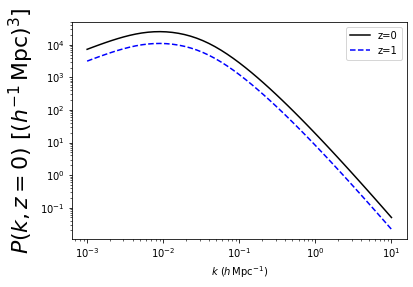

In [14]:
karr = np.logspace(-3, 1, 51)

z=0
Deltasq_lin      = [Deltasq_Pk_linear  (z, k, A, H0, Om, Ob, ns) for k in karr]
prefac           = [(2*np.pi**2)/k**3 for k in karr]
Pk_lin           = [a*b for a, b in zip(prefac,Deltasq_lin)]

z=1
Deltasq_lin_z1   = [Deltasq_Pk_linear  (z, k, A, H0, Om, Ob, ns) for k in karr]
Pk_lin_z1        = [a*b for a, b in zip(prefac,Deltasq_lin_z1)]

plt.loglog(karr,Pk_lin, 'k', label='z=0')
plt.loglog(karr,Pk_lin_z1, 'b', ls='dashed', label='z=1')

plt.legend(loc="upper right")
plt.xlabel(r'$k\,\, (h\,{\rm Mpc}^{-1})$')
plt.ylabel(r'$P(k, z=0)\,\, [(h^{-1}\,{\rm Mpc})^3]$', fontsize=22)

Now we are ready to calculate the amplitude of mass fluctuations $\sigma(z, M)$ -- first and foremost, the quantity $\sigma_8$ evaluated at $z=0$.

The equation is, recall

$ \sigma^2(z, R) = \displaystyle\int_0^\infty \Delta^2(k) \left ({3j_1(kR)\over kR}\right )^2 d\ln k$

Helpful: the spherical Bessel function of the first kind is, in scipy.spherical, given by sp.spherical_jn(1,x).

In [8]:
import scipy.special as sp
###############################
# sigma(z, R)
###############################  
def integrand_sigma_sq(log10k, r, z, A_k005, H0, Om, Ob, ns):
    k = 10**log10k
    x = k*r
    # below is expression, which when multiplied by dlog10(k) = 1/ln(10) * dk/k gives the right thing
    return (3*sp.spherical_jn(1,x)/x)**2 * Deltasq_Pk_linear(z, k, A_k005, H0, Om, Ob, ns) * np.log(10.0)

def sigma(r, z, A_k005, H0, Om, Ob, ns):
    # integrate in the log; scale upper limit by r (not required)
    log10_kmax = 2 + np.log10(8.0/r)
    sigsq = quad(integrand_sigma_sq, -3, log10_kmax, args=(r, z, A_k005, H0, Om, Ob, ns), limit = 1000)[0]
    return np.sqrt(sigsq)

# now report sigma8 when ready:
print('Sigma8=', sigma(8.0, 0.0, A, H0, Om, Ob, ns))

Sigma8= 0.5372204082498632


Now define the Press-Schechter mass function. The formula is:
$\displaystyle{dn\over d\ln M} = \sqrt{2\over \pi}\,{\rho_{M, 0}\over M}\,{\delta_c\over\sigma}\left |{d\ln\sigma\over d\ln M}\right |
\, e^{-\delta_c^2/(2\sigma^2)}$

where $\delta_c=1.686$ is critical overdensity for collapse from the spherical collapse model. 

It will take you a bit of effort to code this up without mistakes. Note that you need $\sigma(M, z)$, while you have previously defined $\sigma(R, z)$. Mass and radius are, fortunately, related simply here:

$M = \displaystyle\frac{4\pi}{3}\rho_M(z=0)R^3$

where $\rho_M(z=0)$ is the physical matter density evaluated at the present time. Note that, if you work in your favorite units where $R$ is in $h^{-1}\,{\rm Mpc}$ and mass is in $h^{-1}\,M_\odot$.  
So you can still work off of your function $\sigma(R, z)$ by converting $M$ into $R$ in your mass function definition.

In [9]:
from scipy.misc import derivative

DELTA_C = 1.686  ## critical overdensity of the spherical collapse
CRIT_DENS = 2.775e11 ## (h^{-1}M_sun) / (h^{-1} Mpc)^3 */
def rho_m(z, Om):
    return CRIT_DENS*Om*(1+z)**3

def dn_dlnM(z, M, A_k005, H0, Om, Ob, ns):
    # important: convert mass into equivalent R
    R = (3*M/(4*np.pi*rho_m(0, Om))) **(1/3) ## in h^{-1} Mpc
    sig =  sigma(R, z, A_k005, H0, Om, Ob, ns)  # note that growth D is already in sigma

    # need a derivative
    dR = 0.02*R
    # dlnM = 3*dlnR + const, so dR/dM = (1/3) * R/M
    dR_dM = (1/3)* R/M    
    dsigma_dR = derivative(sigma, R, dx=dR, n=1, args=(z, A_k005, H0, Om, Ob, ns))
    dsigma_dM = dsigma_dR * dR_dM      
    dlnsig_dlnM_abs = M/sig * np.abs(dsigma_dM)
    
    return np.sqrt(2.0/np.pi) * rho_m(0, Om)/M * dlnsig_dlnM_abs * DELTA_C/sig * np.exp(-0.5*(DELTA_C/sig)**2)  

Next, plot the mass function $dn/d\ln M$ over the range $z\in[0, 5]$ for three choices of mass $M=[10^{13}, 10^{14}, 10^{15}]h^{-1}\,M_\odot$. 

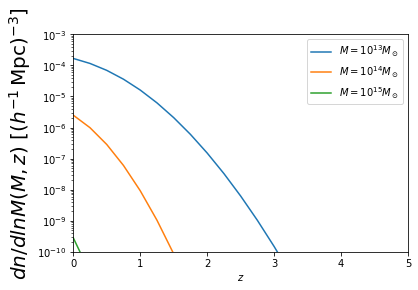

In [10]:
zarr = np.linspace(0, 5, 21)
dn_dlnM_arr_13 = [dn_dlnM(z, 1e13, A, H0, Om, Ob, ns) for z in zarr]
dn_dlnM_arr_14 = [dn_dlnM(z, 1e14, A, H0, Om, Ob, ns) for z in zarr]
dn_dlnM_arr_15 = [dn_dlnM(z, 1e15, A, H0, Om, Ob, ns) for z in zarr]

plt.xlim(0, 5)
plt.ylim(1.0e-10, 0.001)
plt.xlabel(r'$z$')
plt.ylabel(r'$dn/dlnM (M, z)\,\, [(h^{-1}\,{\rm Mpc})^{-3}]$', fontsize=20)

plt.yscale('log')
plt.plot(zarr, dn_dlnM_arr_13, label=r'$M=10^{13}M_\odot$')
plt.plot(zarr, dn_dlnM_arr_14, label=r'$M=10^{14}M_\odot$')
plt.plot(zarr, dn_dlnM_arr_15, label=r'$M=10^{15}M_\odot$')

plt.legend(loc="upper right")

plt.show()

Finally, calculate the number of clusters (halos) with $M>10^{14}\,h^{-1}N_\odot$. Assume that your survey covers 5,000 sq. deg. on the sky (how many steradians is that?) and spans redshifts $0<z<1$.  

You will use the formula from the lecture

$\displaystyle N(>M_{\rm th}) = \int d\Omega\,\int dz \int_{M_{\rm th}}^\infty d\ln M\,\frac{dn}{d\ln M} \frac{dV}{d\Omega\, dz}.$

Potentially helpful: the volume element is 

$\displaystyle \frac{dV}{d\Omega dz} = \frac{r^2(z)}{H(z)}$.

Note that, because $r(z)$ goes as $1/H_0$, and $H(z)$ obviously goes as $H_0$, the volume element goes as $1/H_0^3$, as expected. It's easiest to code it up as $1/H_0^3$ (in the right units!) times dimensionless functions.

In [11]:
# survey area, in staeradians
Omega_survey = 5000.0 * 4*np.pi/42000.0  ## in steradians

#first I need the volume element which is a function of z
def dV_domegadz(z):  
  # overall H0^{-3} scaling; note need units inverse of those of n(z)
  H0_inv_cubed = 2997.9**3  # (h^{-1} Mpc)^3
  return H0_inv_cubed * rz(z, Om, Ok, w)**2 * dist_integrand(z, Om, Ok, w)

# a litttle-bit pedestrian but clear way to integrate over z and M
ZMAX=1
NZ = 10
zarr = np.linspace(0, ZMAX, NZ)
dz = ZMAX/NZ

NM = 20
log10M_arr = np.linspace(14, 15, NM)
dlog10M = (15-14)/NM   

total = 0
for i in range(log10M_arr.size):
  # get M from log10(M)
  M = 10**(log10M_arr[i])

  # convert to dln(M)
  dlnM = np.log(10) * dlog10M

  #sum up over all z
  temp = [dV_domegadz(z)*dn_dlnM(z, M, A, H0, Om, Ob, ns)*dz*dlnM*Omega_survey for z in zarr]
  total = total +  sum(temp)

print('Total number of clusters:', total)

Total number of clusters: 374.04588690720755


Now repeat the same calculation above except in the Einstein-de Sitter model with $\Omega_M=1$. You don't have to write any new code, just go to the most recent code box, and at its beginning add the new value of $\Omega_M$. What do you notice about your result??


#### But that's actually not what you want *either* - you want to find 68\%, 96% etc percentiles of the weights - that is, sum up the weights from highest and go down until you hit 68% etc of the total sum.

Do this as a homework problem. One brute-force way to do it would be to rank-order the weights array from the largest to the smallest value, and start adding the weights until yoou hit 68% of the total sum of weights. Keep track of the corresponding parameter sets for those highest weights, and plot their union in the, say, $\Omega_M-\Omega_\Lambda$ plane.

###Can you can improve the efficiency of your walk? 
####Say you have a long and thin posterior (which is most often true at some level, esp in high dimensions). Rather than making uncorrelated steps in each parameter direction, it is better to step along the "long" and "short" directions - that is, eigendirections of Cov of the posterior at that point.

### For optional homework:

    - take the posterior covariance of the transpose of your existing chain
    - find the Cholesky decomposition `chol` (matrix square-root) of the posterior covariance
    - make a new proposal `chol @ r` where `r` is a vector of random Gaussian numbers with variance of one

